In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import os
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count

In [24]:
def find_op(kwargs):
    series = kwargs['series']
    perc = kwargs['perc']
    n_days = kwargs['n_days']
    name = kwargs['name']
    rolling = series.rolling(window=n_days)
    max_values = rolling.max().shift(-n_days)
    min_values = rolling.min().shift(-n_days)
    inc_op = max_values > series * (1 + perc)
    dec_op = min_values < series * (1 - perc)
    return pd.DataFrame({'total': inc_op.shape[0] - n_days,
                         'inc_prob': sum(inc_op) / (inc_op.shape[0] - n_days),
                         'dec_prob': sum(dec_op) / (dec_op.shape[0] - n_days)
                        }, 
                        index=[name])

In [25]:
def find_prob_total(gpd, func, n_days=10, threshold=.7, perc=.1):
    with Pool(cpu_count()) as p:
        ret_list = p.map(
            func, 
            [
                {
                    'n_days': n_days,
                    'threshold': threshold,
                    'perc': perc,
                    'series': group['Close'],
                    'other': group['Close'].iloc[-n_days:],
                    'name': name
                } 
                for name, group in gpd
            ]
        )
    return pd.concat(ret_list)

In [26]:
price_path = '/Users/feizhan/Dropbox/Project2M/ASXYearlyCompanyConsolidation/'

In [27]:
years = [2013, 2014, 2015, 2016]
dat = pd.DataFrame({})
for year in years:
    dat = dat.append(pd.read_csv(os.path.join(price_path, str(year)+'price.csv')))

In [28]:
gpd = dat.groupby('code')

In [29]:
%time ops = find_prob_total(gpd, find_op)

CPU times: user 2.44 s, sys: 276 ms, total: 2.72 s
Wall time: 3.99 s


In [30]:
ops.head()

,dec_prob,inc_prob,total
1AL.AX,0.000000,0.000000,103
1PG.AX,0.302433,0.384705,863
1ST.AX,0.469565,0.334783,230
3DM.AX,0.325829,0.322275,844
3PL.AX,0.123667,0.083156,469


In [33]:
ops.loc[((0.5 < ops.prob) & (ops.prob < 0.55)).values]

,prob,total
code,,
HZR.AX,0.531646,42.0
ISX.AX,0.510740,428.0
LCD.AX,0.502387,421.0
LSR.AX,0.505967,424.0
MEY.AX,0.508353,426.0
MNB.AX,0.509524,428.0
NIU.AX,0.501788,421.0
RFT.AX,0.512515,430.0
TYK.AX,0.530393,445.0


In [8]:
start_year = 2011
end_year = 2016
start = pd.datetime(start_year, 1, 1)
end = pd.datetime(end_year, 12, 31)
code = 'AJL.AX'
code_dat = web.DataReader(code, 'yahoo', start, end)

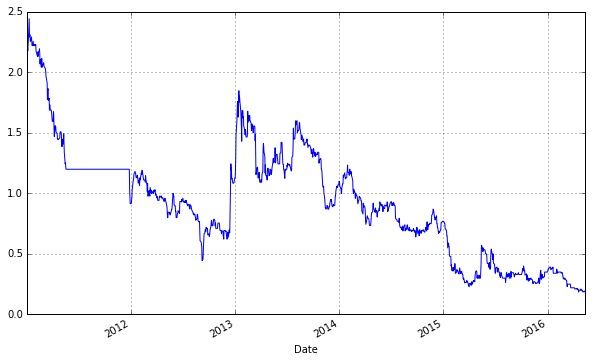

In [9]:
plt.figure(figsize=(10, 6))
code_dat.loc[:, 'Close'].plot(kind='line')
plt.grid()

In [22]:
def find_single_op(series, perc=0.1, n_days=10):
    rolling = series.rolling(window=n_days)
    max_values = rolling.max().shift(-n_days)
    min_values = rolling.min().shift(-n_days)
    inc_op = max_values > series * (1 + perc)
    dec_op = min_values < series * (1 - perc)
    return pd.DataFrame({'total': [inc_op.shape[0] - n_days], 
                         'inc_prob': [sum(inc_op) / (inc_op.shape[0] - n_days)],
                         'dec_prob': [sum(dec_op) / (dec_op.shape[0] - n_days)]
                        })

In [23]:
find_single_op(code_dat.loc[:, 'Close'], perc=0.15, n_days=30)

,dec_prob,inc_prob,total
0,0.466451,0.299919,1237
